# Commented code for exoplanet detection in RV data via machine learning approach. Work based on Nieto and Diaz paper.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import george
from george import kernels
from sklearn import gaussian_process
from astropy.timeseries import LombScargle
import random 
from scipy.stats import loguniform, gamma, uniform
import time 
import os
import pickle
from scipy import interpolate, integrate
import tensorflow as tf
from tensorflow.keras import layers, models

2023-06-29 10:37:59.258466: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
### Function needed to create dataset ### 

def lorentzian_components(params_gr, t):
    '''
    Simulated effects of pulsations and granulations
    
    source: Dumusque et al 2011
    https://www.aanda.org/articles/aa/pdf/2011/01/aa14097-10.pdf
    
    Inputs :
        - params_gr := A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste
        - t = time in seconds
        
    Output :
        - ysyn = Time series corresponding to puslations and granulations (m/s)

    ''' 
    
    # define frequency arrays  
    # The frequency ν goes from 1/T to the Nyquist frequency in steps of 1/T
    N    = len(t)
    Ttot = (max(t)-min(t)) # total time in seconds
    dt = np.median(np.diff(t)) # sampling rate
    freq_Nyq = (1.0/dt)/2 # Nyquist frequency
    freq  = np.arange(1.0/Ttot,freq_Nyq,1.0/Ttot, dtype='float64')

    # define the power spectra as a sum of 3 components for granulation, mesogranulation and supergranulation + oscillations
    A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste = params_gr 
    
    VPSD = A1 / (1+(B1*freq)**C1) + A2 / (1+(B2*freq)**C2) +  A3 / (1+(B3*freq)**C3) + \
                AL * (Gm**2/((freq-nu0)**2+Gm**2)) +  cste  
    
    VPSD *= (freq[-1] - freq[0])
           
    # take random phase between 0 and 2pi
    phase = 2*np.pi*np.random.rand(1,len(VPSD))
    
    # Synthetic radial velocity measurements
    ysyn = np.zeros(N)
    for i in range(N):
        ysyn[i] = np.sum(np.sqrt(VPSD)*np.sin(2*np.pi*t[i]*freq+phase))
       
    return ysyn




def generate_data_H0(params_gr, params_act, t):
    
    '''
    Simulate a time series with all stellar activity components (m/s)
    Inputs:
    - params_gr:= see function lorentzian_components(params_gr, t)
    - params_act:=
            - amplitude (GP amplitude)
            - gam = 2/epsilon in the paper (GP gamma)
            - logP = log(P) in the paper (GP period)
            - met = 1.0 in the paper (GP metric)
    
    - N = number of data points
        
    Outputs:
        - y = RV corresponding to H0(m/s)
        - yerr =  intrinsic errors (m/s)
    '''
    
    # =========================================================================
    # Generate a Lorentzian component that represents the pulsations and
    # three components for the granulation, mesogranulation and su-
    # pergranulation
    ts    = t*24*3600 # seconds
    ygr = lorentzian_components(params_gr, ts)
    
    # =========================================================================
    # Generate activity component based on GP
    
    # define the QP kernel for the GP (see https://george.readthedocs.io/en/latest/user/kernels/)
    """
     amp, gam, logP, met  = params_act
    k  = kernels.ExpSine2Kernel(gamma=gam, log_period=logP)
    k *= kernels.ExpSquaredKernel(metric=met) # metric correspondind to r^2/lambda  is 1
    k *= amp**2 
    
    #define a gaussian process with kernel k
    gp = george.GP(k)

    # generate synthetic time series to simulate effect of rotational modulation
    yact = gp.sample(t)
    
    """
    tau, epsilon, Prot, amp = params_act
    k = gaussian_process.kernels.RBF(tau)
    k*= gaussian_process.kernels.ExpSineSquared(np.sqrt(epsilon),Prot)
    k*= amp**2
    
    gp = gaussian_process.GaussianProcessRegressor(k)
    t_gp = np.reshape(t, (t.shape[0],1))

    yact = gp.sample_y(t_gp, n_samples = 100)[:,np.random.randint(0,100)]
    
    
    # =========================================================================
    # Generate the intrincsic errors
    eb = np.random.normal(loc=3,scale=0.30, size=len(t)) # m/s
    if (any(eb < 0)) : eb = np.where(eb<0, 1.5, eb)
    yerr = np.random.normal(loc=0, scale=eb, size=len(t)) # this has to be defined according to the paper

    # =========================================================================
    # Generate the final synthetic time series
    # activity + granulation + the intrinsic errors 
    ytot = ygr + yact + yerr * np.random.randn(len(t))
    
    return ytot, eb




def generate_planete(params_pl,t):
    """
    Generate a sinusoide signal corresponding to exoplanet signature
    
    Inputs :
        - params_pl: Ppl  (Orbital period), K (semi-amplitude), T0 ( Phase à l'origine)
        - t : Time (day)
    Output:
        - RV of exoplanet signature (m/s)
    """
    Ppl, K, T0 = params_pl
    return K*np.sin(2*np.pi*(t-T0)/Ppl)



def print_4periodogramme(GLS,label,freq_pl):
    
    """
    Plot 4 periodogramme generated by generate_4_periodograms function
    
    Input
        - GLS : Array containing Generalized Lomb-Scargle periodogramme
        - Label : Array containing label (0 or 1)
        - freq_pl : Array containing frequencies of signature exoplanet (O if not)
    """
    
    f1,f2,f3,f4 = freq_pl[:]
    l1,l2,l3,l4 = label[:]
    
    plt.figure()
    plt.suptitle("4 Lomb-Scargle peridogramme generated by removing the best fit\n")
    plt.subplot(411),plt.plot(freq, GLS[:,0] , label =l1), plt.legend()
    if (f1!=0) : plt.plot([f1,f1] , [min(GLS[:,0]),max(GLS[:,0])],'r--')
    if (f2!=0) : plt.plot([f2,f2] , [min(GLS[:,0]),max(GLS[:,0])],'g--')
    if (f3!=0) : plt.plot([f3,f3] , [min(GLS[:,0]),max(GLS[:,0])],'b--')
    if (f4!=0) : plt.plot([f4,f4] , [min(GLS[:,0]),max(GLS[:,0])],'y--')

    plt.subplot(412), plt.plot(freq, GLS[:,1] , label =l2), plt.legend()
    if (f1!=0) : plt.plot([f1,f1] , [min(GLS[:,1]),max(GLS[:,1])],'r--')
    if (f2!=0) : plt.plot([f2,f2] , [min(GLS[:,1]),max(GLS[:,1])],'g--')
    if (f3!=0) : plt.plot([f3,f3] , [min(GLS[:,1]),max(GLS[:,1])],'b--')
    if (f4!=0) : plt.plot([f4,f4] , [min(GLS[:,1]),max(GLS[:,1])],'y--')

    plt.subplot(413), plt.plot(freq, GLS[:,2] , label =l3), plt.legend()
    if (f1!=0) : plt.plot([f1,f1] , [min(GLS[:,2]),max(GLS[:,2])],'r--')
    if (f2!=0) : plt.plot([f2,f2] , [min(GLS[:,2]),max(GLS[:,2])],'g--')
    if (f3!=0) : plt.plot([f3,f3] , [min(GLS[:,2]),max(GLS[:,2])],'b--')
    if (f4!=0) : plt.plot([f4,f4] , [min(GLS[:,2]),max(GLS[:,2])],'y--')

    plt.subplot(414 ), plt.plot(freq, GLS[:,3] , label = l4), plt.legend()
    if (f1!=0) : plt.plot([f1,f1] , [min(GLS[:,3]),max(GLS[:,3])],'r--')
    if (f2!=0) : plt.plot([f2,f2] , [min(GLS[:,3]),max(GLS[:,3])],'g--')
    if (f3!=0) : plt.plot([f3,f3] , [min(GLS[:,3]),max(GLS[:,3])],'b--')
    if (f4!=0) : plt.plot([f4,f4] , [min(GLS[:,3]),max(GLS[:,3])],'y--')
    
    plt.xlabel("Frequency (day⁻¹)")
    plt.ylabel("Power")
    

def generate_4_periodograms(t,f, y, freq_pl,nbr_planete,eb):
    
    """
    Generated 4 Generalized Lomb-Scargle periodograms. Take the first time series given in input,
    calculate his GLS, removed the highest peak by fitting a sinusoide at this frequency and substract this 
    sinusoide to the time serie and calculate the GLS to the time series obtained. Repeat this processus 3 times.
    
    Input : 
        - t : time (day)
        - f : frequency ( day⁻1)
        - y : original time serie (m/s)
        - freq_pl : frequencies of exoplanet (day⁻¹)
        - nbr_planete : number of exoplanet in y 
        - eb : error bars (m/s)

    Output :
        - GLS : Generalized Lomb-Scragle periodograms 
        - Label : 1 if one of frequency of freq_pl is the max of the corresponding GLS, 0 either
        - max_value : Argmax and max of the corresponding GLS
        - nbr_planete_now : Number of planet in corresponding GLS 
    """
    
    y_t = np.zeros((len(t), 4)) #time series
    GLS  = np.zeros((len(f), 4)) # GLS
    label= np.zeros(4) #1 if max = freq_pl, 0 else
    max_value = np.zeros((2,4)) # (argmax, max)
    
    
    y_t[:,0] = np.copy(y) # first time serie is given as input
    
    #Loop to create GLS by removing highest peak
    for i in range(3):
        GLS_i =  LombScargle(t, y_t[:,i],eb) 
        GLS[:,i] = GLS_i.power(f,method='cython')
        best_freq = f[np.argmax(GLS[:,i])] # Frequency corresponding to the highest peak 
        max_value[0,i], max_value[1,i] = best_freq, np.max(GLS[:,i]) # ( Argmax, max)
        
        if ( any(np.isclose(freq_pl, best_freq, atol=0.002)) ): 
            # case where best_freq (max of GLS) is corresponding to any frequency planet
            label[i] = 1
            
            # Update the freq_pl and nbr_planete arrays
            ind_freq = np.where( np.isclose(freq_pl, best_freq, atol=0.002) )[0]
            freqs_found = freq_pl[ind_freq]
            ind_freq_found = np.argmin(np.abs(freqs_found - best_freq))
            freq_found = freqs_found[ind_freq_found]
            freq_pl[ np.where (freq_pl == freq_found)] = 0
            nbr_planete[i+1:] = nbr_planete[i] - 1
            
        else:
            # case where best_freq (max of GLS) isn't a frequency planet
            label[i] = 0
        
        # Generate a new time serie by take the ancient one and substract it a sinusoidale signal with frequency corresponding to the highest peak
        y_fit = GLS_i.model(t,best_freq)
        y_t[:,i+1] = y_t[:,i] - y_fit
    
    # Last GLS outside the loop for practical reason
    GLS_i = LombScargle(t, y_t[:,3],eb)
    GLS[:,3] = GLS_i.power(f,method='cython')
    best_freq = f[np.argmax(GLS[:,3])]
    max_value [0,3], max_value[1,3] =  best_freq, np.max(GLS[:,3])
    
    if (any(np.isclose(freq_pl, best_freq, atol=0.002))):
        label[3] = 1
    else:
        label[3] = 0
    
    
    return GLS, label, max_value    



def generate_data(t,dt,Ttot,freq,params_gr, nbr_pl_to_inject):
    
    """
    Generated 4 Generalized Lomb-Scargle periodogramm. Take the first time series given in input,
    calculate his GLS, removed the highest peak by fitting a sinusoide a this frequency and substract this 
    sinusoide to the time serie and calculate the GLS to the time series obtained. Repeat this processus 3 time.
    
    Input : 
        - t : time (day)
        - dt : median time interval (day)
        - Ttot : observation time (day)
        - freq : frequency ( day⁻1)
        - params_gr : see function lorentzian_components(params_gr, t)
        - nbr_pl_to_inject : number of exoplanet to inject in the simulation
        
    Output :
        - GLS : Generalized Lomb-Scragle periodograms 
        - Label : 1 if one of frequency of freq_pl is the max of the corresponding GLS, 0 either
        - max_value : Argmax and max of the corresponding GLS
        - freq_pl : frequencies of exoplanet (day⁻¹)
        - nbr_planete : Number of exoplanet in the corresponding GLS

    """
    
    GLS = np.zeros((len(freq),4)) 
    freq_pl = np.zeros(4)
    nbr_planete = np.zeros(4)
    label = np.zeros((4))
    max_value = np.zeros((2,4))
    
    # GP parameters, randomly chosen in distribution according to the paper
    Prot = random.randint(5,90)
    amp  = gamma.rvs(2.0, 0.5) 
    epsilon = uniform.rvs(0.5, 1)
    tau = np.random.normal(3*Prot, 0.1*Prot) 
    params_act = [tau, epsilon, Prot, amp]
    
    # Generate H0 data, activity signal 
    y_noise, eb = generate_data_H0(params_gr, params_act, t)
    
    #Without planet 
    if ( nbr_pl_to_inject == 0): 
        GLS, label, max_value = generate_4_periodograms(t, freq, y_noise,freq_pl,nbr_planete,eb)
    
    #With planet
    else :
        y_i = y_noise
        # Loop to create a signal with nbr_pl_to_inject planets
        for i in range(1,nbr_pl_to_inject+1):
            # Planet signature parameters, randomly chosen according to the paper
            Ppl =  random.uniform(10*dt,Ttot/2) 
            K = loguniform.rvs(0.1, 10)
            T0 =  random.uniform(0,Ppl)
            params_pl = [Ppl,K,T0]
            
            # Storage of the frequencies planet
            freq_pl[i-1] = 1/Ppl
            
            # Add the planet signal to noise and other planetary signal
            y_pl = generate_planete(params_pl, t)
            y_i += y_pl 
        
        nbr_planete[:] = i
        
        # Create 4 GLS with corresponding label and max value 
        GLS, label, max_value = generate_4_periodograms(t, freq, y_i,freq_pl,nbr_planete,eb)
        
        
    return GLS, label, max_value, freq_pl,nbr_planete



def generate_time(Ttot):
    """
    Generate a time vector quasi-uniformly sampled 
    
    Input :
        - Ttot : Observation time
        
    Output :
        - freq : Frequency vector (Day⁻¹)
        - t : Time vector (Day)
        - dt : Median time interval between 2 points
    """
    
    #Generate time and frequency
    #Over-sampling
    facteur_surech = 10 # Over-sampling factor
    N = Ttot*facteur_surech +1 # number of data point in a regularly sampled grid
    t_over = np.linspace(0,Ttot,N) # time vector over sampling
    
    # Irregular sampling, with normal distribution
    facteur_ech = 20 # factor to amplify irregularity in time sampling on over-sampled time vector
    t = np.zeros(Ttot)
    
    # First and last index treated differently 
    ind0 = round( 0 + facteur_ech*np.abs(np.random.normal(0, 0.1)))
    t[0] = t_over[ ind0 ]
    ind_fin = round( (N-1) - facteur_ech*np.abs(np.random.normal(0, 0.1)))
    t[-1] = t_over[ ind_fin ]
    
    # Take sample from over-sampled time vector according to a normal distribution
    pas = N/Ttot
    for i in range(Ttot-2):
        ind = round((i+1)*pas+facteur_ech*np.random.normal(0, 0.1))
        t[i+1] =  t_over[ind]
    
    # Creation of frequencie vector with 990 points
    dt = np.median(np.diff(t))
    fmin = 1/(t[-1]-t[0])
    fmax = (1/dt)/2 
    freq = np.linspace(fmin,fmax,990)
    
    return freq, t,dt

In [3]:
### Function to create the training dataset ###
def create_train_set(nb_periodogramme, pourcentage_positif, t, dt, Ttot, freq):
    
    """
    Create the dataset used for training the network. This dataset has to be balanced, meaning a same proportion
    of positif and negative label in order to create an unbiased network. Additionnaly, this dataset should have
    same number of samples for each cases (0,1,2,3 and 4 planets), again to create an unbiased network.
    
    Input : 
        - nb_periodogramme : Number of samples wanted
        - pourcentage_positif : Pourcentage of positif sample wanted
        - t : time vector (day)
        - dt : Median time interval between 2 points (day)
        - Ttot : Observation time (day)
        - freq : frequency vector (day⁻¹)
    
    Output :
        X_GLS : Generalized Lomb-Scargle periodograms
        X_max_values : Argmax and max values of the GLS
        Y : Label, 0 or 1 if max correspond to a frequency exoplanet
    """
    
    start = time.time()
    
    count_positif = 0
    count_negatif = 0
    
    count_ech_pos = np.zeros(5)
    count_ech_neg = np.zeros(5)
    
    nb_ech = nb_periodogramme/5 # Number of sample for each case ( 0,1,2,3 and 4 exoplanets)
    nb_with_planete_negatif_label = (((1-pourcentage_positif) -1/5)*nb_periodogramme)/4 # Number of negatif label to create for planetary signal
    
    # Tuples to store outputs
    X_GLS = []
    X_max_values = []
    Y = []

    #Coeff for grannulation simulation
    A1, A2, A3  = 0.027*1e6, 0.003*1e6, 0.3*1e-3*1e6 # m/s
    B1, B2, B3  = 7.4*3600, 1.2*3600, 17.9*60 # seconds
    C1, C2, C3  = 3.1, 3.9, 8.9 # dimensionless
    AL, Gm, nu0 = 2.6*1e-3, 0.36*1e-3, 2.4*1e-3 # (m/s), Hz, Hz
    cste        = 1.4e-4 # (m/s)**2/Hz

    params_gr = [A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste]
    
    
    #Create H0 data until having enough sample (nb_ech)
    while( count_ech_neg[0] < nb_ech):
        GLS, label, max_value, freq_pl,nbr_planete = generate_data(t,dt,Ttot,freq,params_gr, 0)
        for i in range(0,4):
            X_GLS.append(GLS[:,i])
            X_max_values.append(max_value[:,i])
            Y.append(label[i])
            count_ech_neg[0] += 1
            count_negatif += 1
    print(0)
    print("Positif ech : ", count_ech_pos)
    print("Negatif ech : ", count_ech_neg,'\n')
    
    #Create H1 data, loop start from 4 planet in order to create sample generated by removing process
    for k in range(4,0,-1):
        # Create sample until having enough negative and positive samples for each cases 
        while( (count_ech_neg[k] < nb_with_planete_negatif_label) or (count_ech_pos[k] < nb_periodogramme * pourcentage_positif/4)):
            #  Generate samples with first GLS having k exoplanet signature
            GLS, label, max_value, freq_pl,nbr_planete = generate_data(t,dt,Ttot,freq,params_gr, k)
            for i in range(0,4):
                # Negative labels
                if ( (label[i] == 0) and (count_ech_neg[round(nbr_planete[i])] < nb_with_planete_negatif_label) ):
                    X_GLS.append(GLS[:,i])
                    X_max_values.append(max_value[:,i])
                    Y.append(label[i])
                    count_ech_neg[round(nbr_planete[i])] += 1
                    count_negatif += 1
                
                # Positive labels
                if ( (label[i] == 1) and (count_ech_pos[round(nbr_planete[i])] < nb_periodogramme * pourcentage_positif/4) ):
                    X_GLS.append(GLS[:,i])
                    X_max_values.append(max_value[:,i])
                    Y.append(label[i])
                    count_ech_pos[round(nbr_planete[i])] += 1
                    count_positif += 1
                    
        print(k)
        print("Positif ech : ", count_ech_pos)
        print("Negatif ech : ", count_ech_neg,'\n')

    
    print("Nbr de data = ",len(Y))
    print("Total time : ", time.time() - start, " s")
    print("Rapport negatif label = ", Y.count(0)/len(Y))
    return X_GLS, X_max_values, Y

In [4]:
### Function to create the testing dataset ###
def create_test_set(nb_periodogramme, t, dt, Ttot, freq):
    
    """
    Create the dataset used for testing the network, this dataset will be naturraly unbalanced with more
    negative than positive labels. 
    
    Input : 
        - nb_periodogramme : Number of samples wanted
        - t : time vector (day)
        - dt : Median time interval between 2 points (day)
        - Ttot : Observation time (day)
        - freq : frequency vector (day⁻¹)
    
    Output :
        X_GLS : Generalized Lomb-Scargle periodograms
        X_max_values : Argmax and max values of the GLS
        Y : Label, 0 or 1 if max correspond to a frequency exoplanet
    """
        
    count_negatif = 0
    count_positif = 0
    
    nb_ech = nb_periodogramme/5
    count_ech = np.zeros(5)
    
    X_GLS = []
    X_max_values = []
    Y = []
    
    start = time.time()
    
    A1, A2, A3  = 0.027*1e6, 0.003*1e6, 0.3*1e-3*1e6 # m/s
    B1, B2, B3  = 7.4*3600, 1.2*3600, 17.9*60 # seconds
    C1, C2, C3  = 3.1, 3.9, 8.9 # dimensionless
    AL, Gm, nu0 = 2.6*1e-3, 0.36*1e-3, 2.4*1e-3 # (m/s), Hz, Hz
    cste        = 1.4e-4 # (m/s)**2/Hz

    params_gr = [A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste]
    
    
    #Create H0 data until having enough sample (nb_ech)
    while( count_ech[0] < nb_ech):
        GLS, label, max_value, freq_pl,nbr_planete = generate_data(t,dt,Ttot,freq,params_gr, 0)
        for i in range(0,4):
            X_GLS.append(GLS[:,i])
            X_max_values.append(max_value[:,i])
            Y.append(label[i])
            count_ech[0] += 1
            count_negatif += 1
    
    print(0)
    print("Positif number : ", count_negatif)
    print("Negatif number : ", count_positif,'\n')
    
    
    #Create planetary signal, loop start from 4 planet in order to create sample generated by removing process
    for k in range(4,0,-1):
        while( count_ech[k] < nb_ech):
            GLS, label, max_value, freq_pl,nbr_planete = generate_data(t,dt,Ttot,freq,params_gr, k)
            for i in range(0,4):
                if ( count_ech[round(nbr_planete[i])]<nb_ech):
                    X_GLS.append(GLS[:,i])
                    X_max_values.append(max_value[:,i])
                    Y.append(label[i])
                    count_ech[round(nbr_planete[i])] += 1
                    if ( label[i] == 0) : count_negatif += 1 
                    else  : count_positif += 1
                    
        
        print(k)
        print("Positif ech : ", count_positif)
        print("Negatif ech : ", count_negatif,'\n')
        
    print("Nbr de data = ",len(Y))
    print("Total time : ", time.time() - start, " s")
    print("Rapport negatif label = ", count_negatif/len(Y))
    
    return X_GLS, X_max_values, Y


In [5]:
### Create time and frequency arrays ###

Ttot = 200
freq, t, dt = generate_time(Ttot)

In [6]:
### Create training set ###

nb_data = 13700
pourcentage_positif = 0.5
X_GLS, X_max_values, Y = create_train_set(nb_data, pourcentage_positif, t, dt, Ttot, freq)

0
Positif ech :  [0. 0. 0. 0. 0.]
Negatif ech :  [2740.    0.    0.    0.    0.] 

4
Positif ech :  [   0.   23.  435. 1713. 1713.]
Negatif ech :  [2740.  321. 1028. 1028. 1028.] 

3
Positif ech :  [   0.   23.  435. 1713. 1713.]
Negatif ech :  [2740.  321. 1028. 1028. 1028.] 

2
Positif ech :  [   0.  368. 1713. 1713. 1713.]
Negatif ech :  [2740. 1028. 1028. 1028. 1028.] 

1
Positif ech :  [   0. 1713. 1713. 1713. 1713.]
Negatif ech :  [2740. 1028. 1028. 1028. 1028.] 

Nbr de data =  13704
Total time :  489.9506723880768  s
Rapport negatif label =  0.5


In [7]:
### Size/Shape of training dataset ###

N_data = len(X_GLS)
print("X_lS : ", len(X_GLS), type(X_GLS))
print("X_max_values : ", len(X_max_values), type(X_max_values))

print("\n1 periodogramme : ",len(X_GLS[0]), type(X_GLS[0]) ) #periodogramme
print("1 max values : ", len(X_max_values[0]), type(X_max_values[0]) ) #max values 

print("Y : ", len(Y), type(Y))

X_lS :  13704 <class 'list'>
X_max_values :  13704 <class 'list'>

1 periodogramme :  990 <class 'numpy.ndarray'>
1 max values :  2 <class 'numpy.ndarray'>
Y :  13704 <class 'list'>


In [8]:
#### Data train pre-processing ###

#shuffle
c = list(zip(X_GLS, X_max_values,Y))
random.shuffle(c)
X_GLS, X_max_values,Y = zip(*c)

#Periodograms
X_shape =  [N_data,len(X_GLS[0]), 1]
X1_tensor = tf.convert_to_tensor(X_GLS, dtype = 'float32')
X1 = tf.reshape(X1_tensor, X_shape )

#Max values
X2_tensor = tf.convert_to_tensor(X_max_values, dtype = 'float32')
X2 = tf.reshape(X2_tensor, (N_data, 2,1))

#Labels
Y_tensor = tf.convert_to_tensor(Y,dtype='float32')
Y = tf.reshape(Y_tensor, (N_data,1 ))

#Split train/validation
# Validation data will be used to evaluate the network during the training
pourcentage = 0.8
split = round(pourcentage * N_data)
X_train1, X_val1 = X1[0:split, :, :], X1[split:, :, :]
X_train2,X_val2 = X2[0:split, :, :], X2[split:, :, :]
Y_train, Y_val = Y[0:split], Y[split:,:]

print("Periodogramme train size : ", X_train1.shape)
print("Periodogramme validation size : ", X_val1.shape,"\n")
print("Max_values train size : ", X_train2.shape)
print("Max_values validation size : ", X_val2.shape,"\n")
print("Label train size : ", Y_train.shape)
print("Label validation size : ", Y_val.shape)

Periodogramme train size :  (10963, 990, 1)
Periodogramme validation size :  (2741, 990, 1) 

Max_values train size :  (10963, 2, 1)
Max_values validation size :  (2741, 2, 1) 

Label train size :  (10963, 1)
Label validation size :  (2741, 1)


2023-06-29 10:46:16.758296: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [9]:
#### Create testing set ###

nb_data = 10000
X_GLS_test, X_max_values_test, Y_test = create_test_set(nb_data, t, dt, Ttot, freq)

0
Positif number :  2000
Negatif number :  0 

4
Positif ech :  2378
Negatif ech :  5149 

3
Positif ech :  2378
Negatif ech :  5149 

2
Positif ech :  2703
Negatif ech :  6053 

1
Positif ech :  2933
Negatif ech :  7067 

Nbr de data =  10000
Total time :  171.78380370140076  s
Rapport negatif label =  0.7067


In [11]:
### Data test pre-procesing ###

#shuffle
c = list(zip(X_GLS_test, X_max_values_test,Y_test))
random.shuffle(c)
X_GLS_test, X_max_values_test,Y_test = zip(*c)

#Periodograms
X1_test_tensor = tf.convert_to_tensor(X_GLS_test, dtype= 'float32')
X1_test_shape =  [len(X_GLS_test),len(X_GLS_test[0]), 1]
X1_test = tf.reshape(X1_test_tensor, X1_test_shape )

#Max values
X2_test_tensor = tf.convert_to_tensor(X_max_values_test, dtype= 'float32')
X2_test = tf.reshape(X2_test_tensor, (len(X_max_values_test), len(X_max_values_test[0]),1))

#Labels
Y_test_tensor = tf.convert_to_tensor(Y_test)
label_test = tf.reshape(Y_test_tensor, (len(Y_test),1 ))

print("X1_test shape : ", X1_test.shape)
print("X2_test shape : ", X2_test.shape)
print("label_test shape : ", label_test.shape)

X1_test shape :  (10000, 990, 1)
X2_test shape :  (10000, 2, 1)
label_test shape :  (10000, 1)


# CNN network

In [12]:
### function for training and evaluate the network ###
from tensorflow.keras import backend as K

# Precision, to quantify falses positives
def precision_m(y_true, y_pred):
    true_positives = K.sum( K.round(K.clip(y_true*y_pred,0,1)) )
    predicted_positives = K.sum( K.round(K.clip(y_pred,0,1)) )
    return true_positives / ( predicted_positives + K.epsilon())

# Recall, to quantify falses negatives
def recall_m(y_true, y_pred):
    true_positives = K.sum( K.round(K.clip(y_true*y_pred,0,1)) )
    real_positives = K.sum( K.round(K.clip(y_true,0,1)) )
    return true_positives / (real_positives + K.epsilon())

# F-score, harmonic mean between precision and recall
def f_score(y_true, y_pred):
    P = precision_m(y_true, y_pred)
    R = recall_m(y_true, y_pred)
    return (2*P*R) / (P+R+K.epsilon())

#Evaluation function for binary classification
def evaluate(y_pred, label): 

    index_n = np.where(label == 0)[0]
    index_p = np.where(label == 1)[0]

    true_positif = (y_pred[index_p] == 1).sum()
    false_positif = (y_pred[index_n] == 1).sum()

    true_negatif = (y_pred[index_n] == 0).sum()
    false_negatif = (y_pred[index_p] == 0).sum()
    
    # Confusion matrix
    m = np.array([
        [true_negatif, false_positif],
        [false_negatif, true_positif]
    ])
    
    precision = true_positif/(true_positif + false_positif + K.epsilon())
    recall = true_positif/(true_positif + false_negatif + K.epsilon())
    f_score = (2*precision*recall)/(precision+recall + K.epsilon())
    
    return precision, recall,f_score, m

In [19]:
"""
CNN network for binary classification.
Network architecture according to the paper. Create with functional API Keras.
Each layer output are passed through a relu activation function.
Inputs : 
    - GLS periodograms vector  of size (990,1) pass through convolutions layers.
    - (Argmax, Max) vector of size (2,1) pass through a single dense layer 

Then the two outputs are concatenated in two a single vector which pass through a final dense layers network.

Output : 
    - Probability of the precence of exoplanet signature in the GLS
    
"""

#GLS periodograms as input to a CNN
inputs1 = tf.keras.Input(shape=(990,1)) # Define the first input
x1 = layers.Conv1D(filters = 32, kernel_size = 2, strides = 1, padding = 'same',
                   activation='relu', use_bias = True,input_shape= (990,1))(inputs1) # Convolution layers with parameters according to the paper
x1 = layers.MaxPooling1D(pool_size = 2, strides = None, padding = 'valid')(x1) #Maxpooling for extract the maximum

x1 = layers.Conv1D(filters = 32,kernel_size = 6,padding = 'same', activation='relu')(x1)
x1 = layers.MaxPooling1D(pool_size = 2, strides = None, padding = 'valid')(x1)

x1 = layers.Conv1D(filters = 32,kernel_size = 8,padding = 'same', activation='relu')(x1)
x1 = layers.MaxPooling1D(pool_size = 2, strides = None, padding = 'valid')(x1)

outputs1 = layers.Flatten()(x1) # Flattening to be able to concatenate


#Max_values as input to a dense layers 
inputs2 = tf.keras.Input(shape=(2,1))
x2 = layers.Dense(2, activation = 'relu', use_bias = True)(inputs2)
outputs2 =  layers.Flatten()(x2) # Flattening to be able to concatenate

#output of the two networks concatenate for input as a dense final network
x = layers.concatenate([outputs1, outputs2])
x = layers.Dense(32, activation = 'relu', use_bias = True)(x)
x = layers.Dense(32, activation = 'relu', use_bias = True)(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1,activation = 'sigmoid')(x) 

In [20]:
model = tf.keras.Model(inputs=[inputs1,inputs2], outputs=outputs, name ="ExoplANNET")
model.summary()

Model: "ExoplANNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 990, 1)]     0           []                               
                                                                                                  
 conv1d_6 (Conv1D)              (None, 990, 32)      96          ['input_5[0][0]']                
                                                                                                  
 max_pooling1d_6 (MaxPooling1D)  (None, 495, 32)     0           ['conv1d_6[0][0]']               
                                                                                                  
 conv1d_7 (Conv1D)              (None, 495, 32)      6176        ['max_pooling1d_6[0][0]']        
                                                                                         

In [21]:
# Define the network training procedure

# Ojbect to stop the training when the monitoring function (f-socre here) evaluate on validation data doesn't get better
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_f_score', patience = 3, mode = "max",
                                                  restore_best_weights = True, start_from_epoch = 5)

# Loss function : Binary cross entropy ( from_logits = False because output between 0 and 1)
# Gradient descent algorithme used : Adam, momentum gradient descend + adaptative learning rate
# Metrics to monitored the training : Binary Accuracy, precision, recall and F-score (define above)
model.compile( loss = tf.keras.losses.BinaryCrossentropy(from_logits= False),
              optimizer = tf.keras.optimizers.Adam(learning_rate = 2e-4),
              metrics =[tf.keras.metrics.BinaryAccuracy(),precision_m, recall_m, f_score])

# First forward without parameters adjustement
y_before_train = model.evaluate( x = [X_train1, X_train2], y = Y_train, batch_size = 128)

86/86 [==============================] - 4s 44ms/step - loss: 0.6930 - binary_accuracy: 0.6134 - precision_m: 0.6530 - recall_m: 0.4883 - f_score: 0.5569


In [22]:
#Train the network

# Training on train data, and evaluation of the model for the metrics on validation data which are not used for
# the training by the network
start = time.time()
history = model.fit(x = [X_train1, X_train2], y = Y_train, batch_size = 128, epochs = 50, verbose = 1,
                    callbacks=[early_stopping], validation_data = ([X_val1,X_val2], Y_val))                                                      
time_train = time.time() - start

Epoch 1/50
86/86 [==============================] - 14s 146ms/step - loss: 0.6220 - binary_accuracy: 0.7378 - precision_m: 0.8525 - recall_m: 0.5882 - f_score: 0.6876 - val_loss: 0.4687 - val_binary_accuracy: 0.8234 - val_precision_m: 0.8248 - val_recall_m: 0.8158 - val_f_score: 0.8183
Epoch 2/50
86/86 [==============================] - 12s 135ms/step - loss: 0.4520 - binary_accuracy: 0.7996 - precision_m: 0.8331 - recall_m: 0.7517 - f_score: 0.7875 - val_loss: 0.4171 - val_binary_accuracy: 0.8289 - val_precision_m: 0.8192 - val_recall_m: 0.8396 - val_f_score: 0.8274
Epoch 3/50
86/86 [==============================] - 11s 132ms/step - loss: 0.4394 - binary_accuracy: 0.8089 - precision_m: 0.8261 - recall_m: 0.7848 - f_score: 0.8027 - val_loss: 0.3982 - val_binary_accuracy: 0.8179 - val_precision_m: 0.8551 - val_recall_m: 0.7621 - val_f_score: 0.8042
Epoch 4/50
86/86 [==============================] - 12s 144ms/step - loss: 0.4243 - binary_accuracy: 0.8165 - precision_m: 0.8258 - recall_

Temps d'entrainement :  316.4233434200287 s


Text(0.5, 0, 'Epochs')

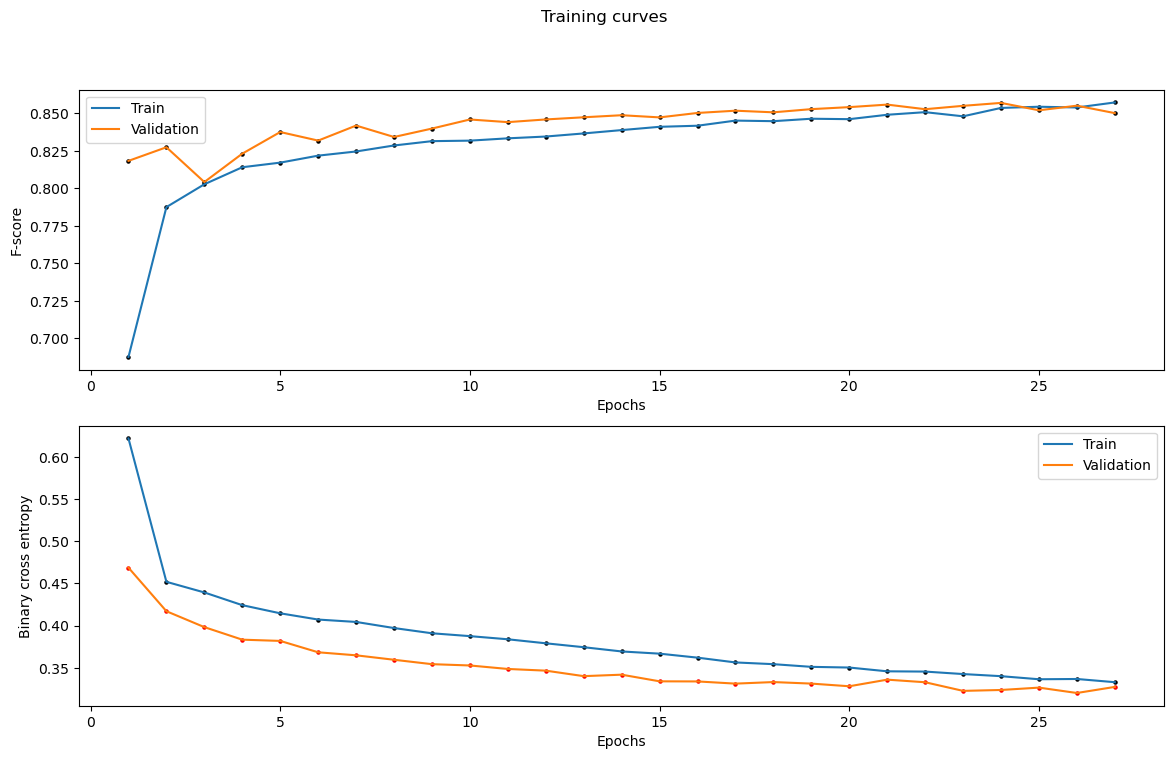

In [23]:
# Ploting of the learning curves (loss function and F-score)

print("Temps d'entrainement : ", time_train, "s")

x = np.arange(1,len(history.history['loss'])+1,1)

plt.figure(figsize=(14,8))
plt.suptitle("Training curves")
plt.subplot(211)
plt.scatter(x,history.history['f_score'], s=5, c='k')
plt.plot(x,history.history['f_score'], label='Train'), plt.legend()
plt.scatter(x,history.history['val_f_score'], s=5, c='k')
plt.plot(x,history.history['val_f_score'], label='Validation'), plt.legend()
plt.ylabel("F-score")
plt.xlabel("Epochs")

plt.subplot(212)
plt.scatter(x,history.history['loss'], s=5, c='k')
plt.plot(x,history.history['loss'], label='Train'), plt.legend()
plt.scatter(x,history.history['val_loss'], s=5, c='r')
plt.plot(x,history.history['val_loss'], label='Validation'), plt.legend()
plt.ylabel("Binary cross entropy")
plt.xlabel("Epochs")

In [24]:
#Evaluation with samples from test dataset
y_pred_cnn1 = model.predict( x =[X1_test, X2_test])

313/313 [==============================] - 14s 44ms/step


Best F-score achieve by CNN =  0.774  with threshold =  0.681
Confusion matrix :  [[6273  794]
 [ 580 2353]]


Text(0, 0.5, 'Pdet')

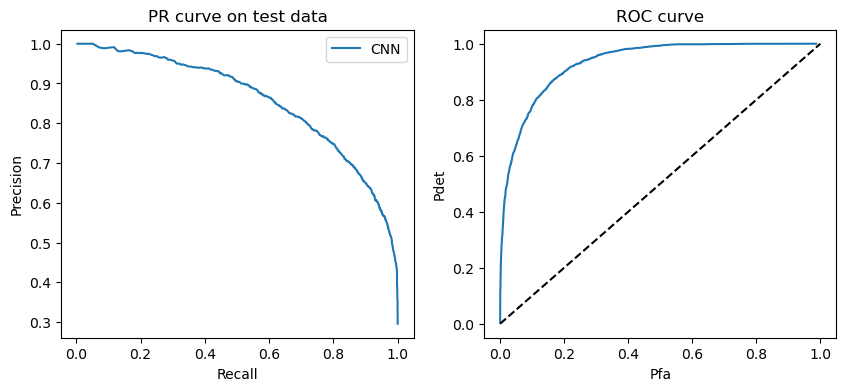

In [25]:
# Plot the PR and ROC curve to asess the network
N = 1000
threshold = np.linspace(0.0001,0.9999,N)
P = np.zeros(N)
R = np.zeros(N)
Pdet = np.zeros(N)
Pfa = np.zeros(N)

best_score = 0

for i in range(N):
    y_seuil = np.where(y_pred_cnn1 > threshold[i],1,0)
    P[i] ,R[i],f,m = evaluate(y_seuil,label_test) 
    Pdet[i], Pfa[i] = m[1,1]/(m[1,1]+m[1,0]), m[0,1]/(m[0,0]+m[0,1])
    if (f > best_score) : best_score, best_threshold, best_m = f, threshold[i], m
        
    
print("Best F-score achieve by CNN = ", round(best_score,3), " with threshold = ",round(best_threshold,3) )
print("Confusion matrix : ", best_m)
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title("PR curve on test data")
plt.plot(R,P, label='CNN'),  plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.subplot(122)
plt.title("ROC curve")
plt.plot(Pfa, Pdet)
plt.plot(np.linspace(0,1,N), np.linspace(0,1,N), '--', c ='black')
plt.xlabel("Pfa")
plt.ylabel("Pdet")

## P-value method ('FAP' in the paper)

In [26]:
def create_pdf(t,freq,N):
    """
    Create a estimation of the probability distribution function of the max amplitude in the GLS
    
    Inputs :
        - t : Time vector (day)
        - freq : Frequency vector (day⁻¹)
        - N : Number of simulation to create to calculate the pdf
        
    Output :
        - pdf : estimation of the probability distribution function of the max amplitude in the GLS under H0 data
    
    """
    
    amps = np.zeros(N)
    
    A1, A2, A3  = 0.027*1e6, 0.003*1e6, 0.3*1e-3*1e6 # m/s
    B1, B2, B3  = 7.4*3600, 1.2*3600, 17.9*60 # seconds
    C1, C2, C3  = 3.1, 3.9, 8.9 # dimensionless
    AL, Gm, nu0 = 2.6*1e-3, 0.36*1e-3, 2.4*1e-3 # (m/s), Hz, Hz
    cste        = 1.4e-4 # (m/s)**2/Hz

    params_gr = [A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste]
    
    for i in range(N):
        
        Prot = random.randint(5,90)#62 # days -- Prot to be chosen randomly in HARPS sample (see paper)
        amp  = gamma.rvs(2.0, 0.5) 
        epsilon = uniform.rvs(0.5, 1)
        tau = np.random.normal(3*Prot, 0.1*Prot)
        params_act = [tau, epsilon, Prot, amp]
        
        y,eb = generate_data_H0(params_gr, params_act,t)
        gls = LombScargle(t,y,eb).power(freq,method='cython')
        amps[i] = max(gls)
        
    pdf = np.histogram(amps, bins = 50, density = True)
    
    return pdf,amps

In [27]:
pdf_mean,amps = create_pdf(t,freq,20000)

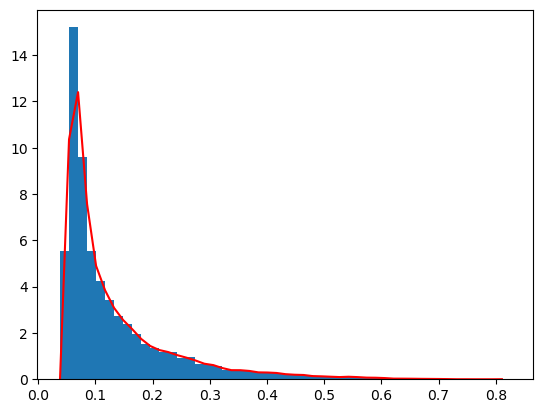

In [92]:
mean_bin = np.zeros(pdf_mean[1].shape[0]-1)
for i in range(pdf_mean[1].shape[0]-1) : mean_bin[i] = (pdf_mean[1][i+1] + pdf_mean[1][i])/2
f_pdf = interpolate.interp1d(mean_bin, pdf_mean[0],bounds_error = False, fill_value = (0,0))

plt.bar(pdf_mean[1][:-1], pdf_mean[0], width=np.diff(pdf_mean[1]), align='edge')
plt.plot(pdf_mean[1][:-1], f_pdf(pdf_mean[1][:-1]), c ='r')

In [93]:
def predict_FAP(Maxs, amps):
    """
    Compute the p-values at value xi on the probality density function pdf
    
    Inputs :
        - Maxs : Argmax and max value of GLS
        - pdf_mean : probality density function of the max amplitude on GLS under H0 data
        
    Output :
        - p_vals : p-value vector
        
    """
    N_test = Maxs.shape[0]
    p_vals = np.zeros(N_test)
    for i in range(N_test):
        p_vals[i] = np.sum(amps[np.where(amps > Maxs[i][1])[0]])/np.sum(amps)
    return p_vals
    

In [94]:
y_pred_FAP_= predict_FAP(X2_test, amps)

/tmp/ipykernel_12396/4158249352.py:29: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  auc1 = integrate.quad(f1, 0, 1)
/tmp/ipykernel_12396/4158249352.py:30: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose i


Best F-score achieve by CNN =  0.774  with threshold =  0.681
Confusion matrix : 
 [[6273  794]
 [ 580 2353]]
AUC =  0.858

Best F-score achieve by 'FAP' =  0.731  with threshold =  0.306
Confusion matrix : 
 [[6218  849]
 [ 756 2177]]
AUC =  0.821


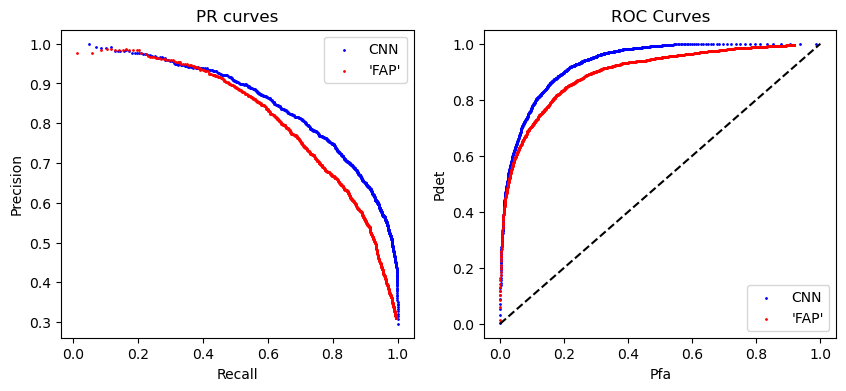

In [95]:
N = 1000
threshold = np.linspace(0.0001,0.9999,N)
P1, R1 = np.zeros(N), np.zeros(N)
Pdet1, Pfa1 = np.zeros(N), np.zeros(N)
False_neg, False_pos = np.zeros(N), np.zeros(N)
P2, R2 = np.zeros(N), np.zeros(N)
Pdet2, Pfa2 = np.zeros(N), np.zeros(N)

best_score_fap = 0
best_score_cnn = 0

for i in range(N):
    y_seuil = np.where(y_pred_cnn1 > threshold[i],1,0)
    P1[i] ,R1[i],f,m = evaluate(y_seuil,label_test)
    Pdet1[i], Pfa1[i] = m[1,1]/(m[1,1]+m[1,0]), m[0,1]/(m[0,0]+m[0,1])
    False_pos[i],False_neg[i] = m[0][1], m[1][0]
    if (f > best_score_cnn) : best_score_cnn, best_threshold_cnn, best_m_cnn = f, threshold[i], m
         
    y_seuil = np.where(y_pred_FAP < threshold[i],1,0)
    P2[i] ,R2[i],f,m = evaluate(y_seuil,label_test)
    Pdet2[i], Pfa2[i] = m[1,1]/(m[1,1]+m[1,0]), m[0,1]/(m[0,0]+m[0,1])
    if (f > best_score_fap) : best_score_fap, best_threshold_fap, best_m_fap = f, threshold[i], m
 
        
x_interp = np.linspace(0,1,N)
f1 = interpolate.interp1d(R1, P1,bounds_error = False, fill_value = (1,0))
f2 = interpolate.interp1d(R2, P2,bounds_error = False, fill_value = (1,0))

auc1 = integrate.quad(f1, 0, 1)
auc2 = integrate.quad(f2, 0, 1)

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title("PR curves")
plt.scatter(R1[:-2],P1[:-2], label ='CNN',s = 1, c ='b'), plt.legend()
plt.scatter(R2,P2, label="'FAP'",s = 1, c ='r'),  plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")

plt.subplot(122)
plt.title("ROC Curves")
plt.scatter(Pfa1, Pdet1, label='CNN', s=1, c='b'),plt.legend()
plt.scatter(Pfa2, Pdet2, label="'FAP'", s=1, c='r'),plt.legend()
plt.plot(x_interp, x_interp, '--', c='black')
plt.xlabel("Pfa")
plt.ylabel("Pdet")

print("\nBest F-score achieve by CNN = ", round(best_score_cnn,3), " with threshold = ",round(best_threshold_cnn,3) )
print("Confusion matrix : \n", best_m_cnn)
print("AUC = ", round(auc1[0],3))
print("\nBest F-score achieve by 'FAP' = ", round(best_score_fap,3), " with threshold = ",round(best_threshold_fap,3) )
print("Confusion matrix : \n", best_m_fap)
print("AUC = ", round(auc2[0],3))